In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [11]:
import os
import requests

def download_file_from_google_drive(file_id, dest_path):
    URL = f"https://docs.google.com/spreadsheets/d/{file_id}/export?format=csv"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : file_id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : file_id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, dest_path)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, dest_path):
    CHUNK_SIZE = 32768

    with open(dest_path, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [12]:
download_file_from_google_drive(file_id='1avc4YanDVFclJgRQKteiNoPY-2TnfXoCf2IRsjoN_jU',
                                    dest_path='./sample_data/data.csv')
df = pd.read_csv('./sample_data/data.csv')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Дата      1461 non-null   object
 1   Значение  1461 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.0+ KB


In [79]:
df["date"] = pd.to_datetime(df["Дата"])
df["year"] = df["date"].dt.year.astype("int")
df["month"] = df["date"].dt.month.astype("int")
df["week"] = df["date"].dt.week.astype("int")
df["day"] = df["date"].dt.day.astype("int")
display(df.agg({"date":["min","max"]}))
df.info()

,date
min,2014-01-05
max,2018-12-04


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461 entries, 0 to 1460
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Дата      1461 non-null   object        
 1   Значение  1461 non-null   int64         
 2   date      1461 non-null   datetime64[ns]
 3   year      1461 non-null   int64         
 4   month     1461 non-null   int64         
 5   week      1461 non-null   int64         
 6   day       1461 non-null   int64         
 7   sum       1461 non-null   int64         
 8   count     1461 non-null   int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 114.1+ KB


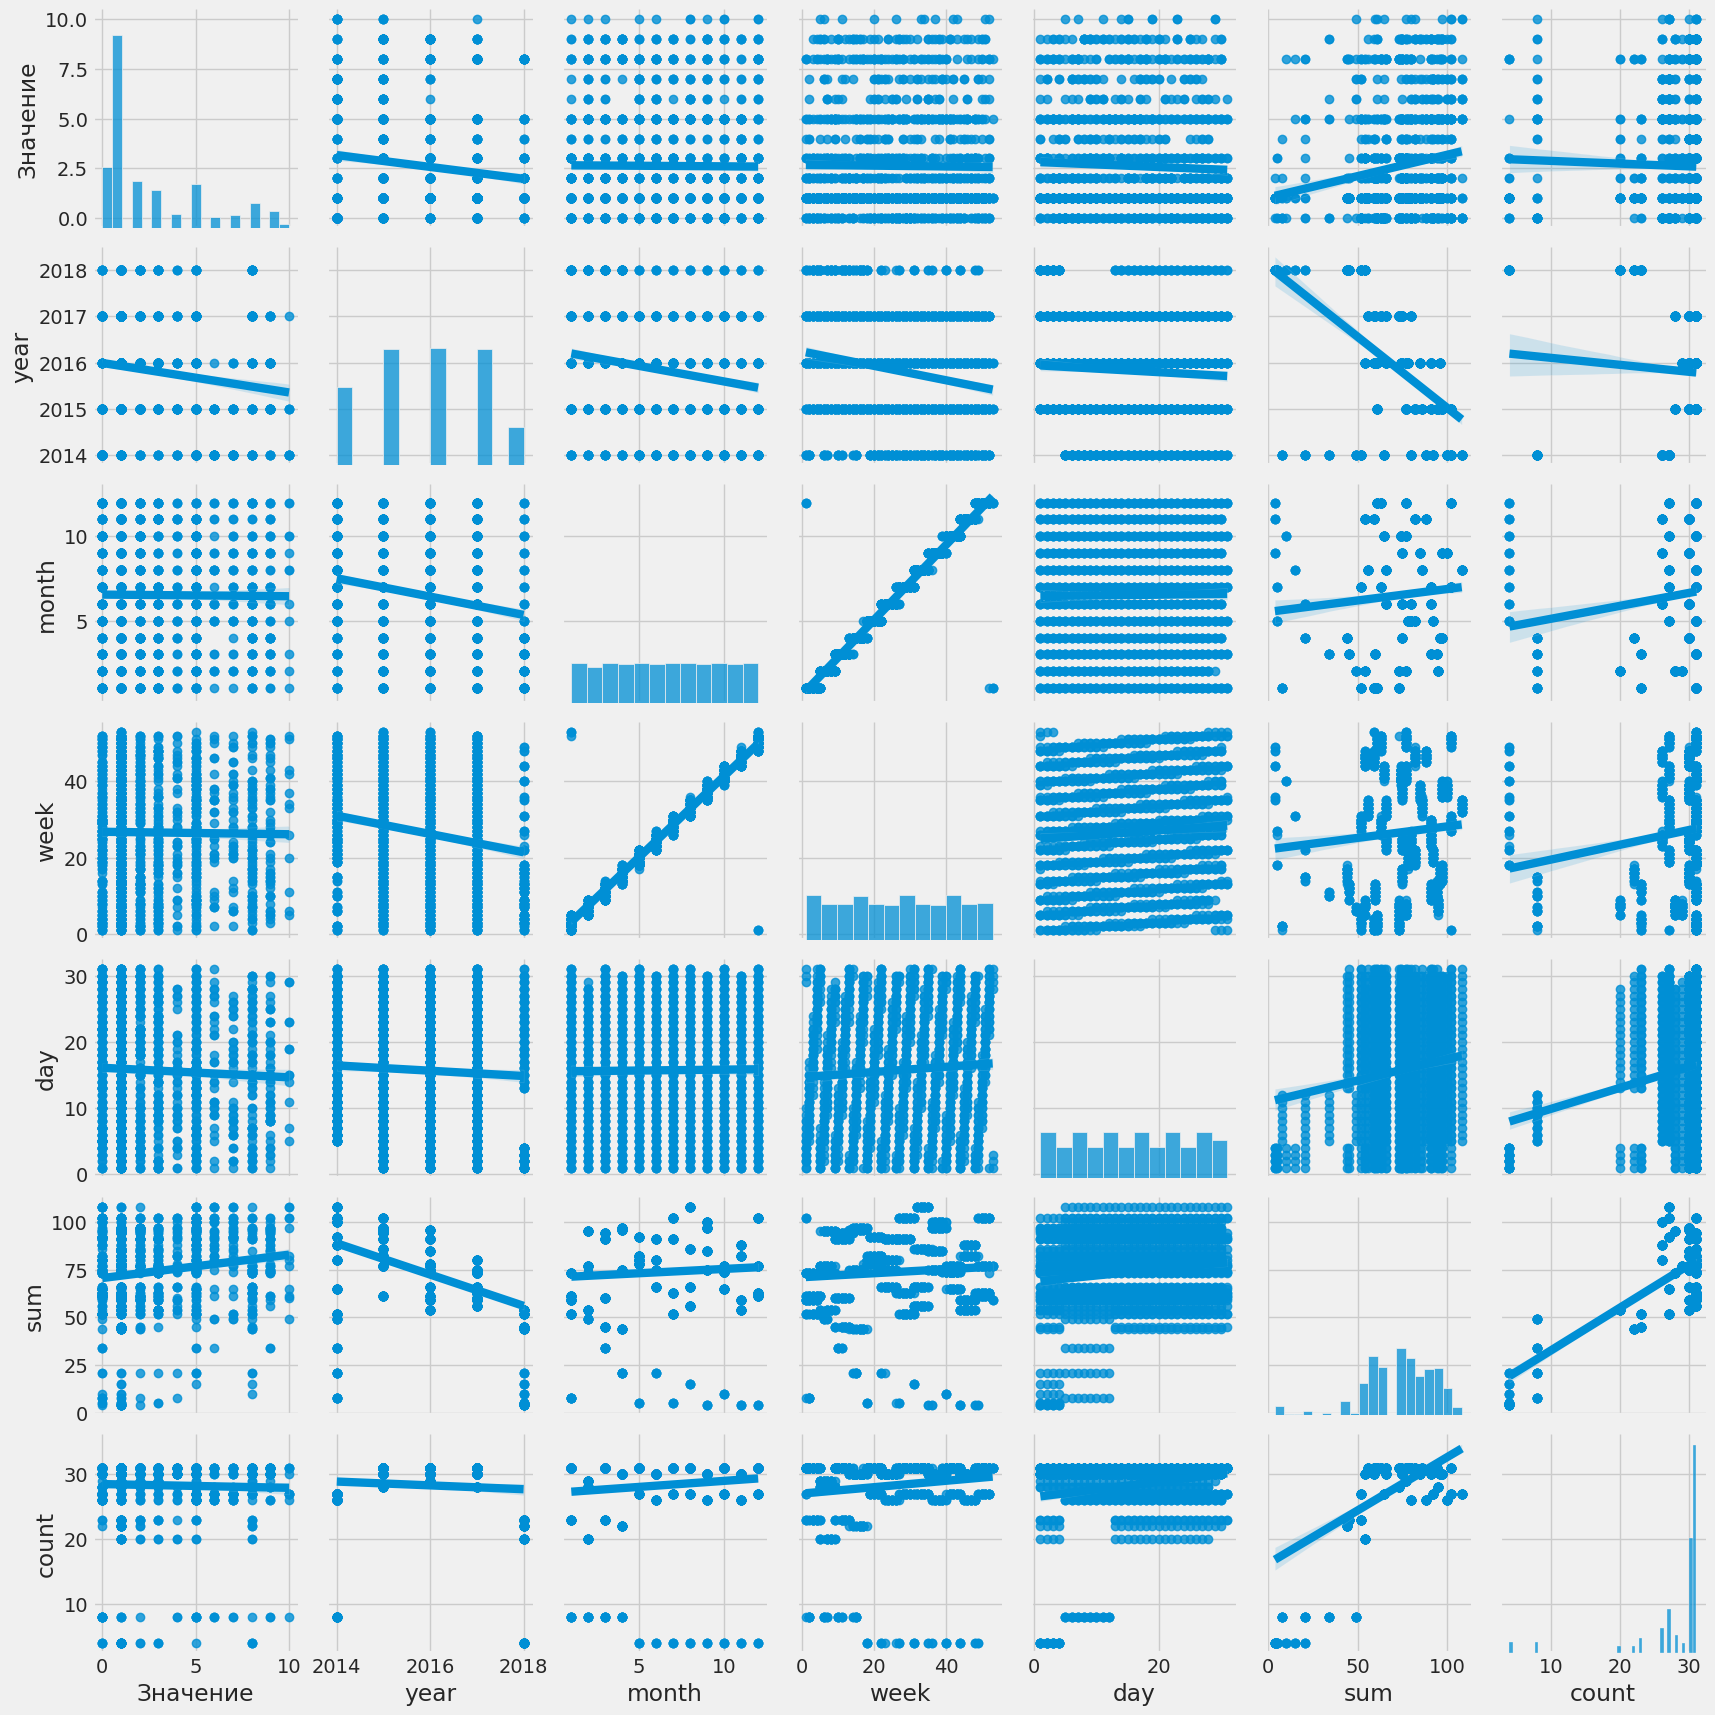

In [89]:
graph = sns.pairplot(df, kind='reg')

EDA did not reveal a correlation between time and value, we are trying to calculate aggregates

In [16]:
dg = df.groupby(["year", "month"]).agg({"Значение":["sum","count"]}).reset_index()
dg = pd.DataFrame({"year": dg["year"], "month": dg["month"], "sum": dg["Значение"]["sum"], "count": dg["Значение"]["count"]})
df = df.merge(dg, left_on=["year", "month"], right_on=["year", "month"])

Text(0.5, 1.0, 'Correlation of values')

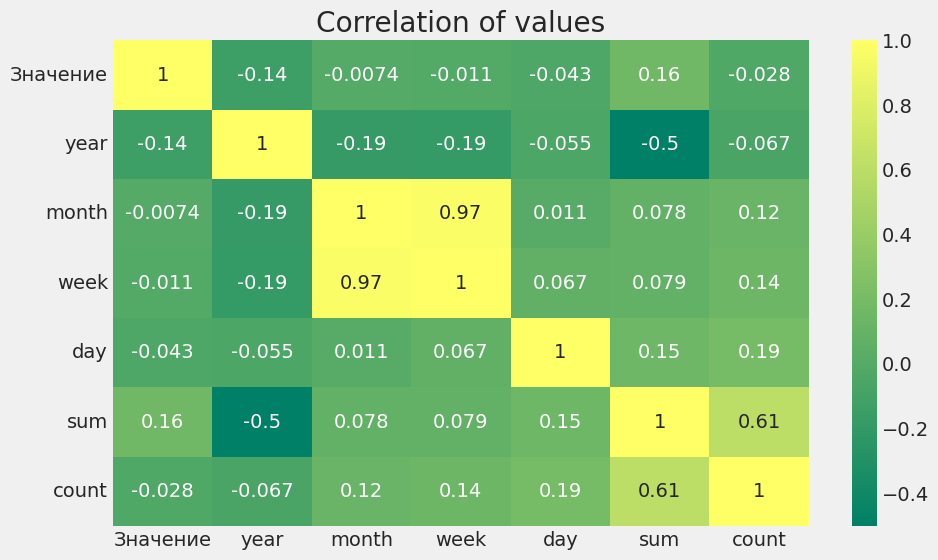

In [17]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='summer')
plt.title('Correlation of values')

The average correlation with the sum is found, we predict its change

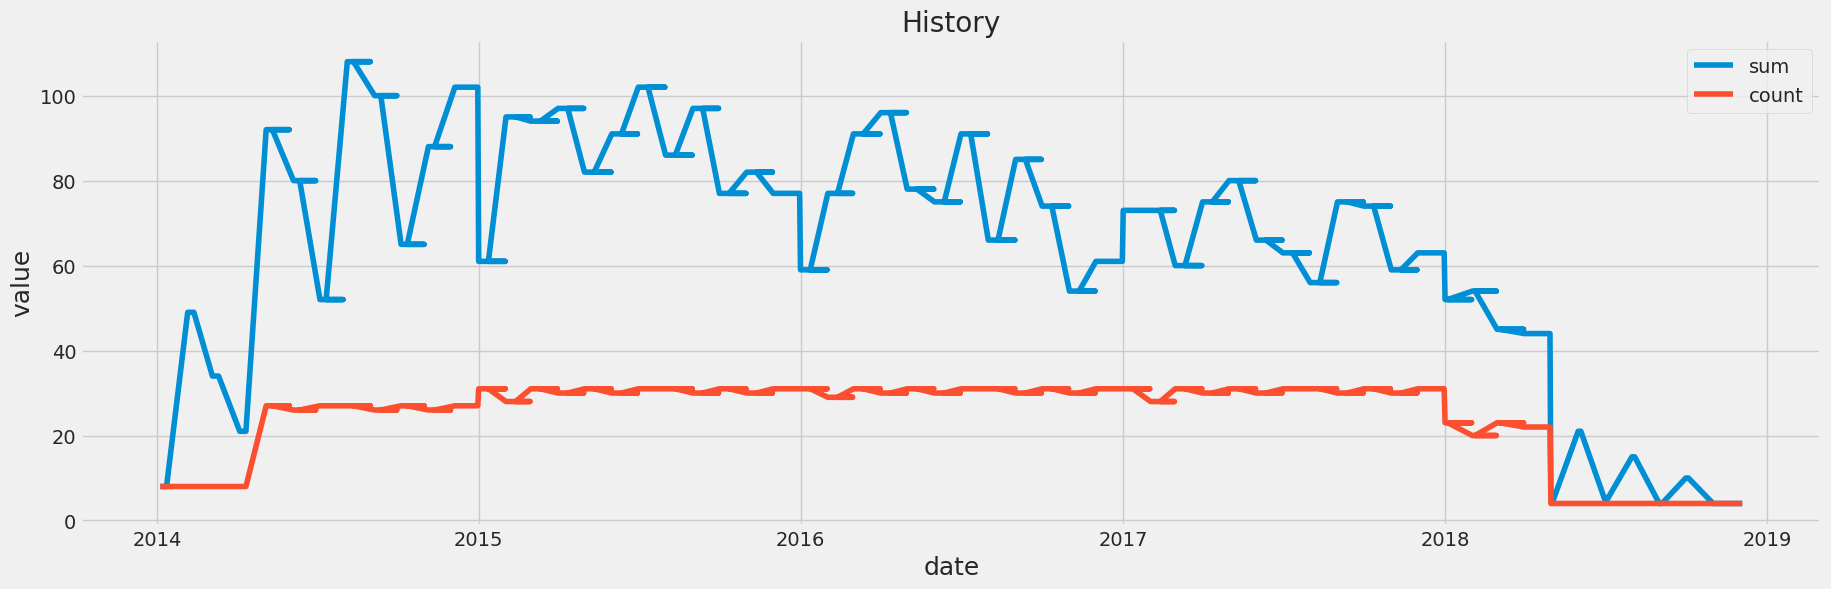

In [26]:
plt.figure(figsize=(20,6))
plt.title('History')
plt.plot(df["date"], df["sum"])
plt.plot(df["date"], df["count"])
plt.xlabel('date', fontsize=18)
plt.ylabel('value', fontsize=18)
plt.legend(['sum', 'count'])
plt.show()

Let's try to predict the remaining 5%

In [81]:
# Create a new dataframe with only the sum column
data = df.filter(["date", "sum"])
# Convert the dataframe to a numpy array
dataset = data.filter(["sum"]).values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

1388

In [58]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.03846154],
       [0.03846154],
       [0.03846154],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [87]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [38]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1328/1328 [==============================] - 86s 62ms/step - loss: 0.0056


In [33]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

3/3 [==============================] - 1s 31ms/step


9.406816061090018

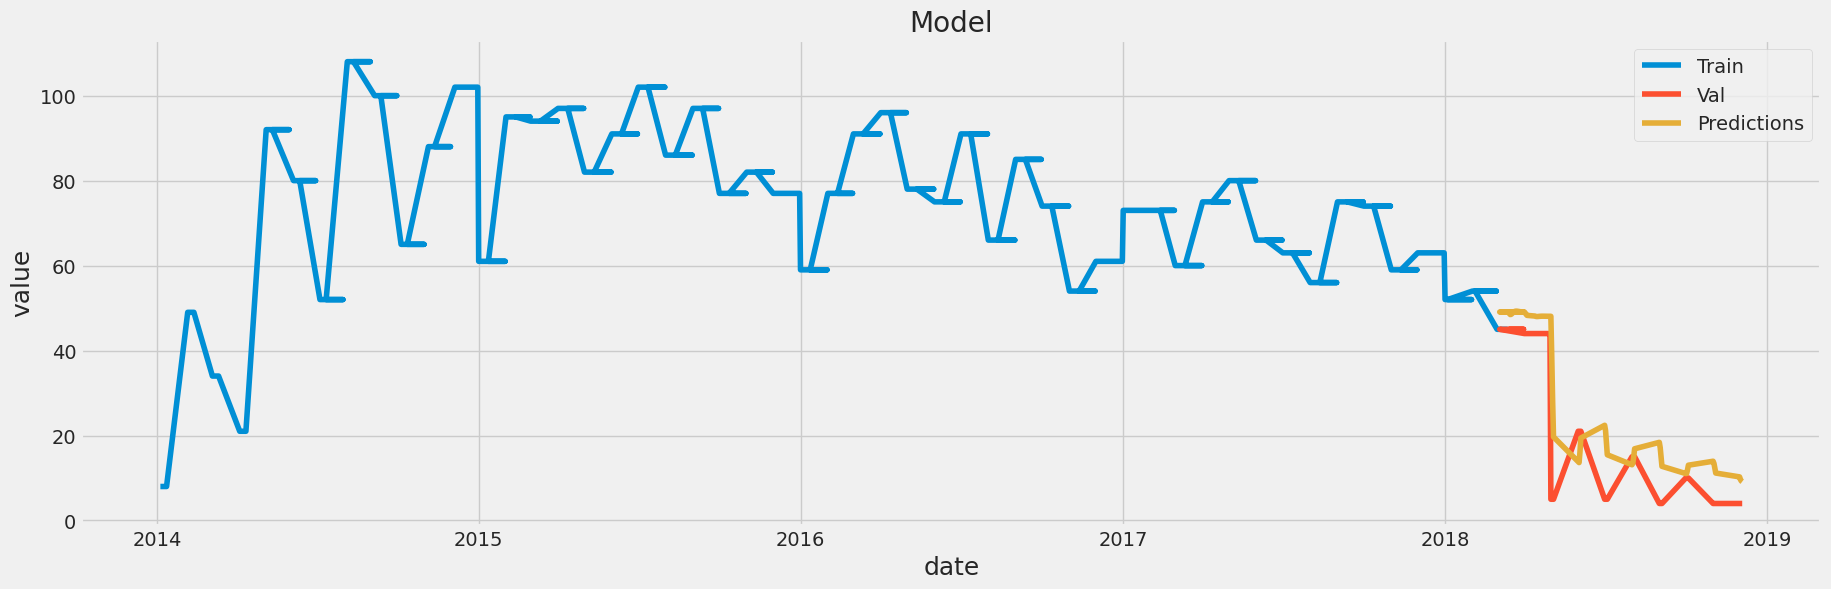

In [77]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(20,6))
plt.title('Model')
plt.xlabel('date', fontsize=18)
plt.ylabel('value', fontsize=18)
plt.plot(train["date"], train['sum'])
plt.plot(valid["date"], valid[['sum', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()